# Real-time video segmentation

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, ignite, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import synapseclient" || pip install -q synapseclient
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'synapseclient'


## Imports

In [2]:
import cv2
from glob import glob
import os
import synapseclient
import synapseutils
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import torch

import monai
from monai.data import (
    Dataset,
    DataLoader,
)
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks import eval_mode
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    AddChanneld,
    AsChannelFirstd,
    AsDiscrete,
    Compose,
    DivisiblePadd,
    LoadImaged,
    ScaleIntensityd,
    ToTensord,
)
from monai.utils import set_determinism

monai.config.print_config()

# Set deterministic training for reproducibility
set_determinism(seed=0)

MONAI version: 0.5.2+54.gba03150
Numpy version: 1.20.2
Pytorch version: 1.9.0a0+2ecb2c7
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: ba03150db03ade15e4868b888fb4edcdb45ee726

Optional dependencies:
Pytorch Ignite version: 0.4.4
Nibabel version: 3.2.1
scikit-image version: 0.18.1
Pillow version: 8.2.0
Tensorboard version: 2.5.0
gdown version: 3.13.0
TorchVision version: 0.9.1+cu102
ITK version: 5.1.2
tqdm version: 4.60.0
lmdb version: 1.2.1
psutil version: 5.8.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/home/rbrown/Documents/Data/MONAI


## Download data from synapse

In [4]:
data_dir = os.path.join(root_dir, "endovis_2017")
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")

if not os.path.isfile(os.path.join(data_dir, "SYNAPSE_METADATA_MANIFEST.tsv")):
    syn_user = os.environ.get("SYNAPSE_USER")
    syn_pwd = os.environ.get("SYNAPSE_PWD")
    project_id = "syn22410924"
    print("getting data from https://www.synapse.org/#!Synapse:" + project_id)

    os.makedirs(data_dir, exist_ok=True)
    syn = synapseclient.login(email=syn_user, password=syn_pwd, rememberMe=True)
    _ = synapseutils.syncFromSynapse(syn, entity=project_id, path=data_dir)

In [5]:
def get_data(folder):
    images = sorted(glob(os.path.join(folder, "*[!seg].png")))
    labels = sorted(glob(os.path.join(folder, "*_seg.png")))
    return [{"image": i, "label": l} for i, l in zip(images, labels)]


train_file_dict = get_data(train_dir)
val_file_dict = get_data(val_dir)

print("Num training image/label pairs", len(train_file_dict))
print("Num validation image/label pairs", len(val_file_dict))

Num training image/label pairs 1616
Num validation image/label pairs 184


In [6]:
keys = ["image", "label"]
transforms = Compose([
    LoadImaged(keys),
    AsChannelFirstd("image"),
    AddChanneld("label"),
    DivisiblePadd(keys, 16),
    ScaleIntensityd(keys),
    ToTensord(keys),
    #     AsDiscreted("label", threshold_values=True),
])

In [7]:
def get_ds_and_dl(data, transforms):
    ds = Dataset(data=data, transform=transforms)
    dl = DataLoader(ds, batch_size=2, num_workers=0)
    return ds, dl


train_ds, train_dl = get_ds_and_dl(train_file_dict, transforms)
val_ds, val_dl = get_ds_and_dl(val_file_dict, transforms)

## Show selection

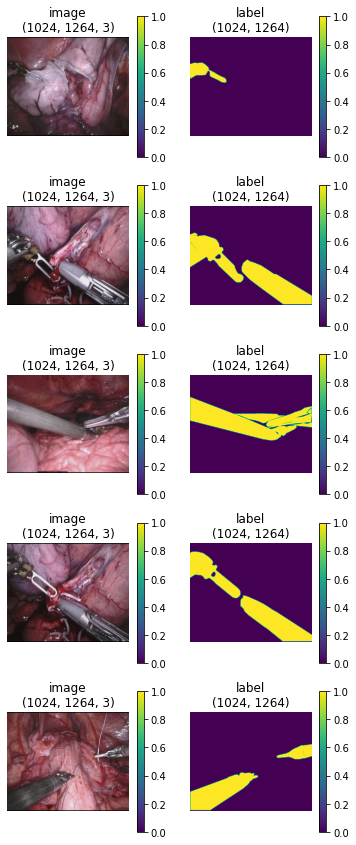

In [8]:
%matplotlib inline
def imshows(ims):
    nrow = len(ims)
    ncol = len(ims[0])
    fig, axes = plt.subplots(nrow, ncol, figsize=(
        ncol * 3, nrow * 3), facecolor='white')
    for i, im_dict in enumerate(ims):
        for j, (title, im) in enumerate(im_dict.items()):
            if isinstance(im, torch.Tensor):
                im = im.detach().cpu().numpy()
            # If RGB put, to end. Else, average across channel dim
            im = np.moveaxis(im, 0, -1) if im.shape[0] == 3 else np.mean(im, axis=0)

            ax = axes[j] if len(ims) == 1 else axes[i, j]
            ax.set_title(f"{title}\n{im.shape}")
            im_show = ax.imshow(im)
            ax.axis("off")
            fig.colorbar(im_show, ax=ax)


to_imshow = []
for data in np.random.choice(val_ds, size=5, replace=False):
    to_imshow.append({"image": data["image"], "label": data["label"]})
imshows(to_imshow)

In [9]:
def plot_range(data, wrapped_generator):
    # Get ax, show plot, etc.
    plt.ion()
    for d in data.values():
        ax = d["line"].axes
    fig = ax.get_figure()
    fig.show()

    for i in wrapped_generator:
        yield i
        # update plots, legend, view
        for d in data.values():
            d["line"].set_data(d["x"], d["y"])
        ax.legend()
        ax.relim()
        ax.autoscale_view()
        fig.canvas.draw()

In [10]:
# Create network, loss fn., etc.
dice_metric = DiceMetric(include_background=False, reduction="mean")
post_trans = Compose([
    Activations(sigmoid=True),
    AsDiscrete(threshold_values=True),
])
in_channels = train_ds[0]["image"].shape[0]
# create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(
    dimensions=2,
    in_channels=in_channels,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)
loss_function = DiceLoss(include_background=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

In [11]:
def infer_seg(images, model):
    return post_trans(model(images))

<IPython.core.display.Javascript object>


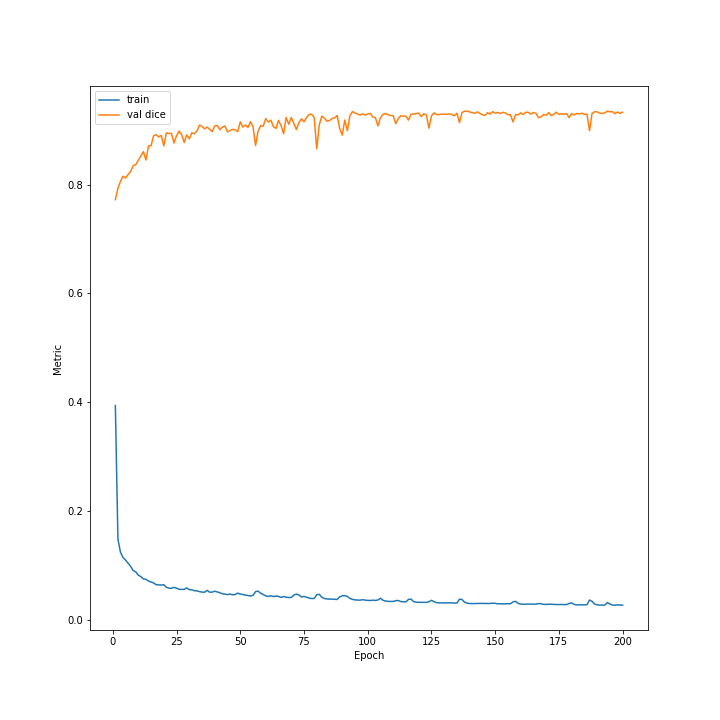

train completed, best_metric: 0.9354 at epoch: 194


In [12]:
%matplotlib notebook

best_model_path = "best_model_video_seg.pth"
always_train = True
do_training = always_train or not os.path.isfile(best_model_path)

if do_training:
    # Plotting stuff
    fig, ax = plt.subplots(1, 1, figsize=(10, 10), facecolor="white")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Metric")

    data = {}
    for i in ["train", "val dice"]:
        data[i] = {"x": [], "y": []}
        (data[i]["line"],) = ax.plot(data[i]["x"], data[i]["y"], label=i)

    # start a typical PyTorch training
    max_epochs = 200
    val_interval = 1
    best_metric = -1
    best_metric_epoch = -1

    for epoch in plot_range(data, range(max_epochs)):
        model.train()
        epoch_loss = 0

        for batch_data in train_dl:
            inputs, labels = batch_data["image"].to(
                device), batch_data["label"].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        epoch_loss /= len(train_dl)
        data["train"]["x"].append(epoch + 1)
        data["train"]["y"].append(epoch_loss)

        if (epoch + 1) % val_interval == 0:
            with eval_mode(model):
                metric_sum = 0.0
                metric_count = 0
                val_outputs = None
                for val_data in val_dl:
                    val_images, val_labels = val_data["image"].to(
                        device), val_data["label"].to(device)
                    val_outputs = infer_seg(val_images, model)
                    value, _ = dice_metric(y_pred=val_outputs, y=val_labels)
                    metric_count += len(value)
                    metric_sum += value.item() * len(value)
                metric = metric_sum / metric_count
                data["val dice"]["x"].append(epoch + 1)
                data["val dice"]["y"].append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), best_model_path)

    print(
        f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

In [13]:
model.load_state_dict(torch.load(best_model_path, map_location=device))
_ = model.eval()
# save as jit model
jit_fname = best_model_path[:-4] + "_jit.pt"
torch.jit.save(torch.jit.script(model.cpu()), jit_fname)
_ = model.to(device)

# Check segmentations

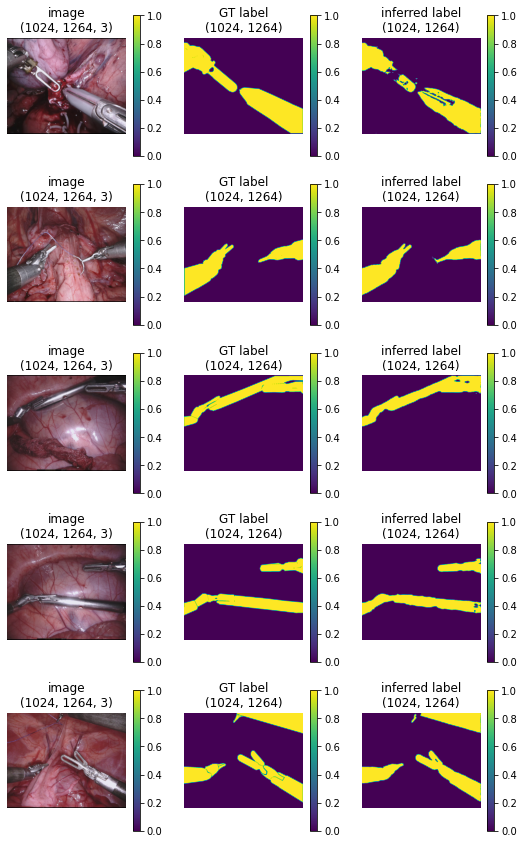

In [14]:
%matplotlib inline
to_imshow = []
for data in np.random.choice(val_ds, size=5, replace=False):
    im, label = data["image"], data["label"]
    im_gpu = im[None].to(device)
    inferred = infer_seg(im_gpu, model)[0]
    to_imshow.append({
        "image": im,
        "GT label": label,
        "inferred label": inferred,
    })
imshows(to_imshow)

## Time the inference

In [15]:
d = transforms(val_file_dict[0])
im_gpu = d["image"][None].to(device)

%timeit infer_seg(im_gpu, model)

16.2 ms ± 2.59 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Generating video

In [16]:


def create_video(in_files, output_file, fps, skip_if_present=False):
    codec = "X264" if output_file[-3:] == "mp4" else "MP42"
    fourcc = cv2.VideoWriter_fourcc(*codec)

    if skip_if_present and os.path.isfile(output_file):
        print(f"video alread present, skipping: {output_file}.")
        return
    print(f"{len(in_files)} frames @ {fps} fps: {output_file}...")

    for idx, image in enumerate(in_files):
        frame = cv2.imread(image)
        if idx == 0:
            width_height = frame.shape[:-1][::-1]
            video = cv2.VideoWriter(output_file, fourcc, fps, width_height)
        video.write(frame)
    video.release()
    if not os.path.isfile(output_file):
        raise RuntimeError("video not created:", output_file)


def create_videos(folder, fps):
    vid_dir = folder + "_videos"
    os.makedirs(vid_dir, exist_ok=True)
    vid_idx = 1
    image_vids, label_vids = [], []
    while True:
        images = sorted(glob(os.path.join(folder, f"d{vid_idx}*[!seg].png")))
        labels = sorted(glob(os.path.join(folder, f"d{vid_idx}*_seg.png")))
        if len(images) == 0:
            break
        image_vids.append(os.path.join(vid_dir, f"d{vid_idx}_im.mp4"))
        label_vids.append(os.path.join(vid_dir, f"d{vid_idx}_seg.mp4"))
        create_video(images, image_vids[-1], fps, skip_if_present=True)
        create_video(labels, label_vids[-1], fps, skip_if_present=True)

        vid_idx += 1
    return image_vids, label_vids


# endovis2017 is 2Hz:
# https://endovissub2017-roboticinstrumentsegmentation.grand-challenge.org/
fps = 2
train_image_vids, train_label_vids = create_videos(train_dir, fps)
val_image_vids, val_label_vids = create_videos(val_dir, fps)

video alread present, skipping: /home/rbrown/Documents/Data/MONAI/endovis_2017/train_videos/d1_im.mp4.
video alread present, skipping: /home/rbrown/Documents/Data/MONAI/endovis_2017/train_videos/d1_seg.mp4.
video alread present, skipping: /home/rbrown/Documents/Data/MONAI/endovis_2017/train_videos/d2_im.mp4.
video alread present, skipping: /home/rbrown/Documents/Data/MONAI/endovis_2017/train_videos/d2_seg.mp4.
video alread present, skipping: /home/rbrown/Documents/Data/MONAI/endovis_2017/train_videos/d3_im.mp4.
video alread present, skipping: /home/rbrown/Documents/Data/MONAI/endovis_2017/train_videos/d3_seg.mp4.
video alread present, skipping: /home/rbrown/Documents/Data/MONAI/endovis_2017/train_videos/d4_im.mp4.
video alread present, skipping: /home/rbrown/Documents/Data/MONAI/endovis_2017/train_videos/d4_seg.mp4.
video alread present, skipping: /home/rbrown/Documents/Data/MONAI/endovis_2017/train_videos/d5_im.mp4.
video alread present, skipping: /home/rbrown/Documents/Data/MONAI/end